In [1]:
%matplotlib inline
import seaborn as sb
import pandas as pd
from tensorflow import keras
from keras import layers
import tensorflow as tf
import os
# Silence TensorFlow from complaining about my NUMA nodes not being countable
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sklearn.metrics
import visualkeras

In [2]:
model_name = 'epoch:0083' # Best Iteration
model_path = os.path.join('./model/checkpoints', model_name)
save_path = './statistics'
test_path = './dataset/test/images/'

# Load dataset

In [3]:
images = []
labels = []
image_dict = {'NORMAL':[], 'PNEUMONIA':[], 'COVID-19':[]}
label_dict = {'NORMAL':[], 'PNEUMONIA':[], 'COVID-19':[]}

file_count = 0

for root, dirs, files in os.walk(test_path):
    for name in files:
        _,_,_,_,label, image = os.path.join(root, name).split(sep='/')
        # Open image and save to list 
        
        image = cv2.resize(cv2.imread(os.path.join(test_path, label, image)).astype(np.uint8), (300, 300), interpolation=cv2.INTER_CUBIC)
        image = image[np.newaxis,:]
        image_dict[label].append(image)
        label_dict[label].append(label)
        file_count += 1
        print('{}/2011 Images Loaded'.format(file_count), end='\r', flush=True)

print('\nCombining Data Classes')
images = image_dict['NORMAL'] + image_dict['PNEUMONIA'] + image_dict['COVID-19']
labels = label_dict['NORMAL'] + label_dict['PNEUMONIA'] + label_dict['COVID-19']
print('Converting to TensorFlow Dataset')
test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
print('dataset loaded')

Combining Data Classesd
Converting to TensorFlow Dataset
dataset loaded


# Conduct prediction of test set

In [6]:
model = keras.models.load_model(os.path.join(model_path))
pred = model.predict(test_dataset, verbose=1)

2011/2011 [==============================] - 24s 11ms/step


# Generate Confusion Matrix

In [9]:
classes = {0: 'NORMAL', 1: 'PNEUMONIA', 2:'COVID-19'}
pred_classes = []
for prediction in pred:
    pred_classes.append(classes[np.argmax(prediction)])

data = {'actual': labels, 'predicted': pred_classes}
    
df = pd.DataFrame(data, columns=['actual', 'predicted'])
df = df.sort_values(by='actual')
confusion_matrix = pd.crosstab(df['actual'], df['predicted'], rownames=['Groundtruth'], colnames=['Prediction'])

sb.heatmap(confusion_matrix, annot=True, square=True, fmt='d', cmap='Blues', cbar=False)
plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), dpi=120, transparent=False)
plt.clf()

<Figure size 432x288 with 0 Axes>

# Generate AUROC

In [10]:
# Needs one-hot encoded labels for some reason
onehot_labels = []

for label in labels:
    if label == 'NORMAL':
        onehot_labels.append([1,0,0])
    elif label == 'PNEUMONIA':
        onehot_labels.append([0,1,0])
    else:
        onehot_labels.append([0,0,1])
        
auc = sklearn.metrics.roc_auc_score(onehot_labels, pred, multi_class='ovo')

    
print('AUC = {}'.format(auc))


AUC = 0.9890595484370951


# Calculate TP, TN, FP, FN

In [11]:
conf = confusion_matrix.values

normal = []
pneumonia = []
covid = []

# order is TP, TN, FP, FN
# TP is the diagonal value
TP = conf[1,1]
# FN = row - TP
FN = sum(conf[1]) - TP
# FP = col - TP
FP = sum(conf[:,1]) - TP
# TN = Total sum - TP - FN - FP
TN = np.sum(conf) - TP - FN - FP
normal = [TP, TN, FP, FN]

# TP is the diagonal value
TP = conf[2,2]
# FN = row - TP
FN = sum(conf[2]) - TP
# FP = col - TP
FP = sum(conf[:,2]) - TP
# TN = Total sum - TP - FN - FP
TN = np.sum(conf) - TP - FN - FP
pneumonia = [TP, TN, FP, FN]

# TP is the diagonal value
TP = conf[0,0]
# FN = row - TP
FN = sum(conf[0]) - TP
# FP = col - TP
FP = sum(conf[:,0]) - TP
# TN = Total sum - TP - FN - FP
TN = np.sum(conf) - TP - FN - FP
covid = [TP, TN, FP, FN]

print('Normal: {}, Pneumonia: {}, COVID-19: {}'.format(normal, pneumonia, covid))

Normal: [976, 939, 50, 46], Pneumonia: [698, 1212, 51, 50], COVID-19: [225, 1759, 11, 16]


# Generate graphs for each class recall, specificity, accuracy

In [12]:
# order is TP, TN, FP, FN
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
# Specificity = TN / (TN + FP)
# f1 = 2TP / (2TP + FP + FN)
n_accuracy = (normal[0] + normal[1]) / sum(normal)
n_precision = normal[0] / (normal[0] + normal[2])
n_recall = normal[0] / (normal[0] + normal[3])
n_specificity = normal[1] / (normal[1] + normal[2])
n_f1 = 2 * normal[0] / (2 * normal[0] + normal[2] + normal[3])
p_accuracy = (pneumonia[0] + pneumonia[1]) / sum(pneumonia)
p_precision = pneumonia[0] / (pneumonia[0] + pneumonia[2])
p_recall = pneumonia[0] / (pneumonia[0] + pneumonia[3])
p_specificity = pneumonia[1] / (pneumonia[1] + pneumonia[2])
p_f1 = 2 * pneumonia[0] / (2 * pneumonia[0] + pneumonia[2] + pneumonia[3])
c_accuracy = (covid[0] + covid[1]) / sum(covid)
c_precision = covid[0] / (covid[0] + covid[2])
c_recall = covid[0] / (covid[0] + covid[3])
c_specificity = covid[1] / (covid[1] + covid[2])
c_f1 = 2 * covid[0] / (2 * covid[0] + covid[2] + covid[3])

print('Normal:\tAccuracy = {},\n\t\tPrecision = {},\n\t\tRecall = {},\n\t\tSpecificity = {},\n\t\tF1 = {}\n'.format(n_accuracy,
                                                                                                      n_precision,
                                                                                                      n_recall,
                                                                                                      n_specificity,
                                                                                                      n_f1))
print('Pneumonia:\tAccuracy = {},\n\t\tPrecision = {},\n\t\tRecall = {},\n\t\tSpecificity = {},\n\t\tF1 = {}\n'.format(p_accuracy,
                                                                                                       p_precision,
                                                                                                       p_recall,
                                                                                                       p_specificity,
                                                                                                       p_f1))
print('COVID-19:\tAccuracy = {},\n\t\tPrecision = {},\n\t\tRecall = {},\n\t\tSpecificity = {},\n\t\tF1 = {}'.format(c_accuracy,
                                                                                                    c_precision,
                                                                                                    c_recall,
                                                                                                    c_specificity,
                                                                                                    c_f1))

Normal:	Accuracy = 0.9522625559423172,
		Precision = 0.9512670565302144,
		Recall = 0.9549902152641878,
		Specificity = 0.9494438827098078,
		F1 = 0.953125

Pneumonia:	Accuracy = 0.9497762307309796,
		Precision = 0.931909212283044,
		Recall = 0.9331550802139037,
		Specificity = 0.9596199524940617,
		F1 = 0.9325317301269205

COVID-19:	Accuracy = 0.9865738438587768,
		Precision = 0.9533898305084746,
		Recall = 0.9336099585062241,
		Specificity = 0.9937853107344633,
		F1 = 0.9433962264150944


# Create Miscellaneous Diagrams

In [10]:
normal_splits = [7146, 2041, 1022]
pneumonia_splits = [5226, 1493, 748]
covid_splits = [1353, 430, 241]
dataset_splits = np.transpose([normal_splits, pneumonia_splits, covid_splits])
train_pre = [7146, 5226, 1353]
train_post = [5209, 5209, 5209]

# Sample distribution (3 total)

# Partition Samples
x_axis = np.arange(len(['Train', 'Validate', 'Test']))
plt.bar(x_axis - 0.2, dataset_splits[0], width=0.2, label = 'Normal')
plt.bar(x_axis, dataset_splits[1], width=0.2, label = 'Pneumonia')
plt.bar(x_axis + 0.2, dataset_splits[2], width=0.2, label = 'COVID-19')
plt.xticks(x_axis, ['Train', 'Validate', 'Test'])
plt.xlabel('Dataset Partition')
plt.ylabel('Samples')
plt.title('Raw Samples per Dataset Partition')

for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i - 0.2, dataset_splits[0,i] + 50, dataset_splits[0,i], ha='center')
for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i, dataset_splits[1,i] + 50, dataset_splits[1,i], ha='center')
for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i + 0.2, dataset_splits[2,i] + 50, dataset_splits[2,i], ha='center')
    
plt.legend()
plt.savefig(os.path.join(save_path, 'dataset_partitioning.png'), dpi=120, transparent=False)
plt.clf()

# Before-After SMOTE
dataset_splits = np.transpose([train_pre, train_post])

x_axis = np.arange(len(['Before SMOTE', 'After SMOTE']))
plt.bar(x_axis - 0.2, dataset_splits[0], width=0.2, label = 'Normal')
plt.bar(x_axis, dataset_splits[1], width=0.2, label = 'Pneumonia')
plt.bar(x_axis + 0.2, dataset_splits[2], width=0.2, label = 'COVID-19')
plt.xticks(x_axis, ['Before SMOTE', 'After SMOTE'])
plt.xlabel('Train Set')
plt.ylabel('Samples')
plt.title('Train Set SMOTE Resampling')

for i in range(len(['Before SMOTE', 'After SMOTE'])):
    plt.text(i - 0.2, dataset_splits[0,i] + 50, dataset_splits[0,i], ha='center')
for i in range(len(['Before SMOTE', 'After SMOTE'])):
    plt.text(i, dataset_splits[1,i] + 50, dataset_splits[1,i], ha='center')
for i in range(len(['Before SMOTE', 'After SMOTE'])):
    plt.text(i + 0.2, dataset_splits[2,i] + 50, dataset_splits[2,i], ha='center')
    
plt.legend()
plt.savefig(os.path.join(save_path, 'resampling.png'), dpi=120, transparent=False)
plt.clf()

# SMOTE Partition Samples
dataset_splits = np.transpose([train_post, pneumonia_splits, covid_splits])
#dataset_splits[0] = train_post

x_axis = np.arange(len(['Train', 'Validate', 'Test']))
plt.bar(x_axis - 0.2, dataset_splits[0], width=0.2, label = 'Normal')
plt.bar(x_axis, dataset_splits[1], width=0.2, label = 'Pneumonia')
plt.bar(x_axis + 0.2, dataset_splits[2], width=0.2, label = 'COVID-19')
plt.xticks(x_axis, ['Train', 'Validate', 'Test'])
plt.xlabel('Dataset Partition')
plt.ylabel('Samples')
plt.title('Raw Samples per Dataset Partition')

for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i - 0.2, dataset_splits[0,i] + 50, dataset_splits[0,i], ha='center')
for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i, dataset_splits[1,i] + 50, dataset_splits[1,i], ha='center')
for i in range(len(['Train', 'Validate', 'Test'])):
    plt.text(i + 0.2, dataset_splits[2,i] + 50, dataset_splits[2,i], ha='center')
    
plt.legend()
plt.savefig(os.path.join(save_path, 'fixed_dataset_partitioning.png'), dpi=120, transparent=False)
plt.clf()

<Figure size 432x288 with 0 Axes>

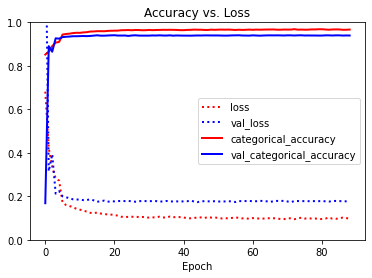

In [36]:
loss = []
val_loss = []
acc = []
val_acc = []
epoch = []

for index, series in pd.read_csv('./model/model_history.csv').iterrows():
    loss.append(series['loss'])
    val_loss.append(series['val_loss'])
    acc.append(series['categorical_accuracy'])
    val_acc.append(series['val_categorical_accuracy'])
    epoch.append(series['epoch'])
    
plt.plot(epoch, loss, linestyle=':', color='red', linewidth=2, label='loss')
plt.plot(epoch, val_loss, linestyle=':', color='blue', linewidth=2, label='val_loss')
plt.plot(epoch, acc, color='red', linewidth=2, label='categorical_accuracy')
plt.plot(epoch, val_acc, color='blue', linewidth=2, label='val_categorical_accuracy')
plt.ylim((0,1))
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy vs. Loss')
plt.savefig(os.path.join(save_path, 'acc_loss.png'), dpi=120, transparent=False)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 301, 301, 3)  0           ['normalization[0][0]']      